In [1]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    ci_perf_on_dset,
    perfs_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range

import matplotlib as mpl
import matplotlib.pyplot as plt

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
# remove all edges

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2

font = {"weight": "bold"}
mpl.rc("font", **font)

# grid alpha to 0.2
mpl.rcParams["grid.alpha"] = 0.2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
from features.features import *

src/username/tmp/NSC/data/dataset_L0_exp_set_0.h5


# Inference using the same validation dataset

get a observed sequence data x_o / seqC_o

In [51]:
DATA_PATH = adapt_path("~/tmp/NSC/data/dataset/dataset-L0-Eset0-100sets-T500.h5")

# load the seqC_o from unseen dataset ['set_25']
with h5py.File(DATA_PATH, "r") as f:
    seqC_o = f['set_25']['seqC'][:]

x_o = seqC2x(seqC_o)
D, M, S = seqC_o.shape[0], seqC_o.shape[1], seqC_o.shape[2]
DMS = D * M * S
print(f"==>> seqC_o.shape: {seqC_o.shape}")
print(f'{seqC_o[0,0,:3,:]=}')
print(f'{x_o[0,0,:3,:]=}')

==>> seqC_o.shape: (7, 3, 700, 15)
seqC_o[0,0,:3,:]=array([[ 0. ,  0. , -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. ,  0. , -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. , -0.2,  0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan]])
x_o[0,0,:3,:]=array([[0.5, 0.5, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0.5, 0.5, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0.5, 0.4, 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ]])


In [53]:
normed_limits = [[0,1], [0,1], [0,1], [0,1]]
# designed_limits = get_limits(config.prior.prior_min, config.prior.prior_max)
designed_limits = [[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]

# prepare varying theta values
print(f"designed_limits\n{designed_limits}")
print(f"normed_limits\n{normed_limits}")

ref_theta_values = [1, 10, 10, 1]

step = 7
theta_values = np.ones((4 * step, 4))
for i in range(len(ref_theta_values)):
    theta_values[:, i] = ref_theta_values[i]

for i, limits in enumerate(designed_limits):
    values = np.linspace(limits[0], limits[1], step)
    theta_values[i * step : (i + 1) * step, i] = values

print(f"\n varying theta_values: \n{theta_values}")

designed_limits
[[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
normed_limits
[[0, 1], [0, 1], [0, 1], [0, 1]]

 varying theta_values: 
[[ -2.5         10.          10.           1.        ]
 [ -1.66666667  10.          10.           1.        ]
 [ -0.83333333  10.          10.           1.        ]
 [  0.          10.          10.           1.        ]
 [  0.83333333  10.          10.           1.        ]
 [  1.66666667  10.          10.           1.        ]
 [  2.5         10.          10.           1.        ]
 [  1.           0.          10.           1.        ]
 [  1.          12.83333333  10.           1.        ]
 [  1.          25.66666667  10.           1.        ]
 [  1.          38.5         10.           1.        ]
 [  1.          51.33333333  10.           1.        ]
 [  1.          64.16666667  10.           1.        ]
 [  1.          77.          10.           1.        ]
 [  1.          10.           0.           1.        ]
 [  1.          10.           3.           1

In [54]:
# run the simulator
params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
    seqCs=seqC_o,
    prior=theta_values,
    num_workers=16,
    privided_prior=True,
)


--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 411600 with 16 workers ...



/tmp/ipykernel_3562239/1837682721.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 464 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 37392 tasks      | elapsed:    6.7s
[Parallel(n_jobs=16)]: Done 126992 tasks      | elapsed:   10.5s
[Parallel(n_jobs=16)]: Done 242192 tasks      | elapsed:   15.7s
[Parallel(n_jobs=16)]: Done 382992 tasks      | elapsed:   22.0s


time elapsed for simulation: 0.39 minutes
stacking the results
done stacking the results

seqC.shape: (7, 3, 700, 15), params.shape: (28, 4), probR.shape: (7, 3, 700, 28, 1)


[Parallel(n_jobs=16)]: Done 411600 out of 411600 | elapsed:   23.4s finished


In [55]:
probR.shape

(7, 3, 700, 28, 1)

In [57]:
chR = torch.tensor(probR).repeat_interleave(10, dim=-1)
chR = torch.bernoulli(chR)
chR = np.array(chR)

print(f"==>> x_o.shape: {x_o.shape}")
print(f"==>> seqC_o.shape: {x_o.shape}")
print(f"==>> probR.shape: {probR.shape}")
print(f"==>> chR.shape: {chR.shape}")

==>> x_o.shape: (7, 3, 700, 15)
==>> seqC_o.shape: (7, 3, 700, 15)
==>> probR.shape: (7, 3, 700, 28, 1)
==>> chR.shape: (7, 3, 700, 28, 10)


In [59]:
# save using torch
valid_data_dir = f"{fig_dir}/compare/dataset_varying_params.pt"
torch.save(
    {
        "x_o": torch.tensor(x_o),
        "seqC_o": torch.tensor(seqC_o),
        "params": torch.tensor(params),
        "probR": torch.tensor(probR),
        "chR": torch.tensor(chR),
        "prior_labels": prior_labels,
        "normed_limits": torch.tensor(normed_limits),
        "designed_limits": torch.tensor(designed_limits),
    },
    valid_data_dir,
)

## Load prepared data

In [61]:
# load the data
fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")
valid_data_dir = f"{fig_dir}/compare/dataset_varying_params.pt"
data = torch.load(valid_data_dir)
x_o = data["x_o"]
seqC_o = data["seqC_o"]
params = data["params"]
probR = data["probR"]
chR = data["chR"]
prior_labels = data["prior_labels"]
normed_limits = data["normed_limits"]
designed_limits = data["designed_limits"]
step = 7
C_idx = 0
nT = 28
M = 3
# DMS = D * M * S

## NPE Inference

load trained NPE model

In [4]:
pipeline_version = "p5a"
train_id = "train_L0_p5a"
exp_id = "p5a-conv_lstm-corr_conv-tmp-4"
log_exp_id = "npe-conv_lstm-mdn"

log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id

config_file = log_dir / "config.yaml"
config = adapt_path(config_file)
with open(config, "r") as f:
    config = yaml.safe_load(f)
config_npe, model_path_npe = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver_npe, posterior_npe, _, _, _, _ = get_posterior(
    model_path=model_path_npe,
    config=config_npe,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=True,
)

==>> config_path: /home/wehe/tmp/NSC/codes/src/train/logs/train_L0_p5a/p5a-conv_lstm-corr_conv-tmp-4/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
--- CUDA info ---



/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
conv_lstm

=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets Loading 18 dataset into memory... 
['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24'] ... 0 2 4 6 8 10 12 14 16  finished in: 0.66s
dur of [3, 9, 15] are chosen, others are [removed] 
[seqC] shape: (18, 3, 3, 700, 15)
[theta] shape: (18, 500, 4)
[probR] shape: (18, 3, 3, 700, 500, 1)
==>> Further Sampling 20 times from probR (given 'in_dataset' process setting) ... in 0.03min
sampled chR shape torch.Size([18, 9, 7

check posterior with varying theta values

In [8]:
nT = params.shape[0]
num_params = len(prior_labels)
all_samples = np.zeros((num_params, step - 2, 20_000, 4))
all_thetas = np.zeros((num_params, step - 2, 4))

for T in range(nT):
    # skip the first and last step cases
    if T % step == 0 or T % step == step - 1:
        continue
    
    # which theta is moving
    moving_theta_idx = T // step
    trial_idx = T % step - 1

    theta_test = torch.tensor(params[T, :]).clone().detach()
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    chR_test = chR[:, T, C_idx].unsqueeze(-1)
    xy_test = torch.cat([x_o, chR_test], dim=-1)

    samples = sampling_from_posterior(
        "cuda",
        posterior_npe,
        xy_test,
        num_samples=20_000,
        show_progress_bars=False,
    )
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

/tmp/ipykernel_3562239/314554964.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_test = torch.tensor(params[T, :]).clone().detach()
/home/wehe/tmp/NSC/codes/src/utils/range.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)
/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(

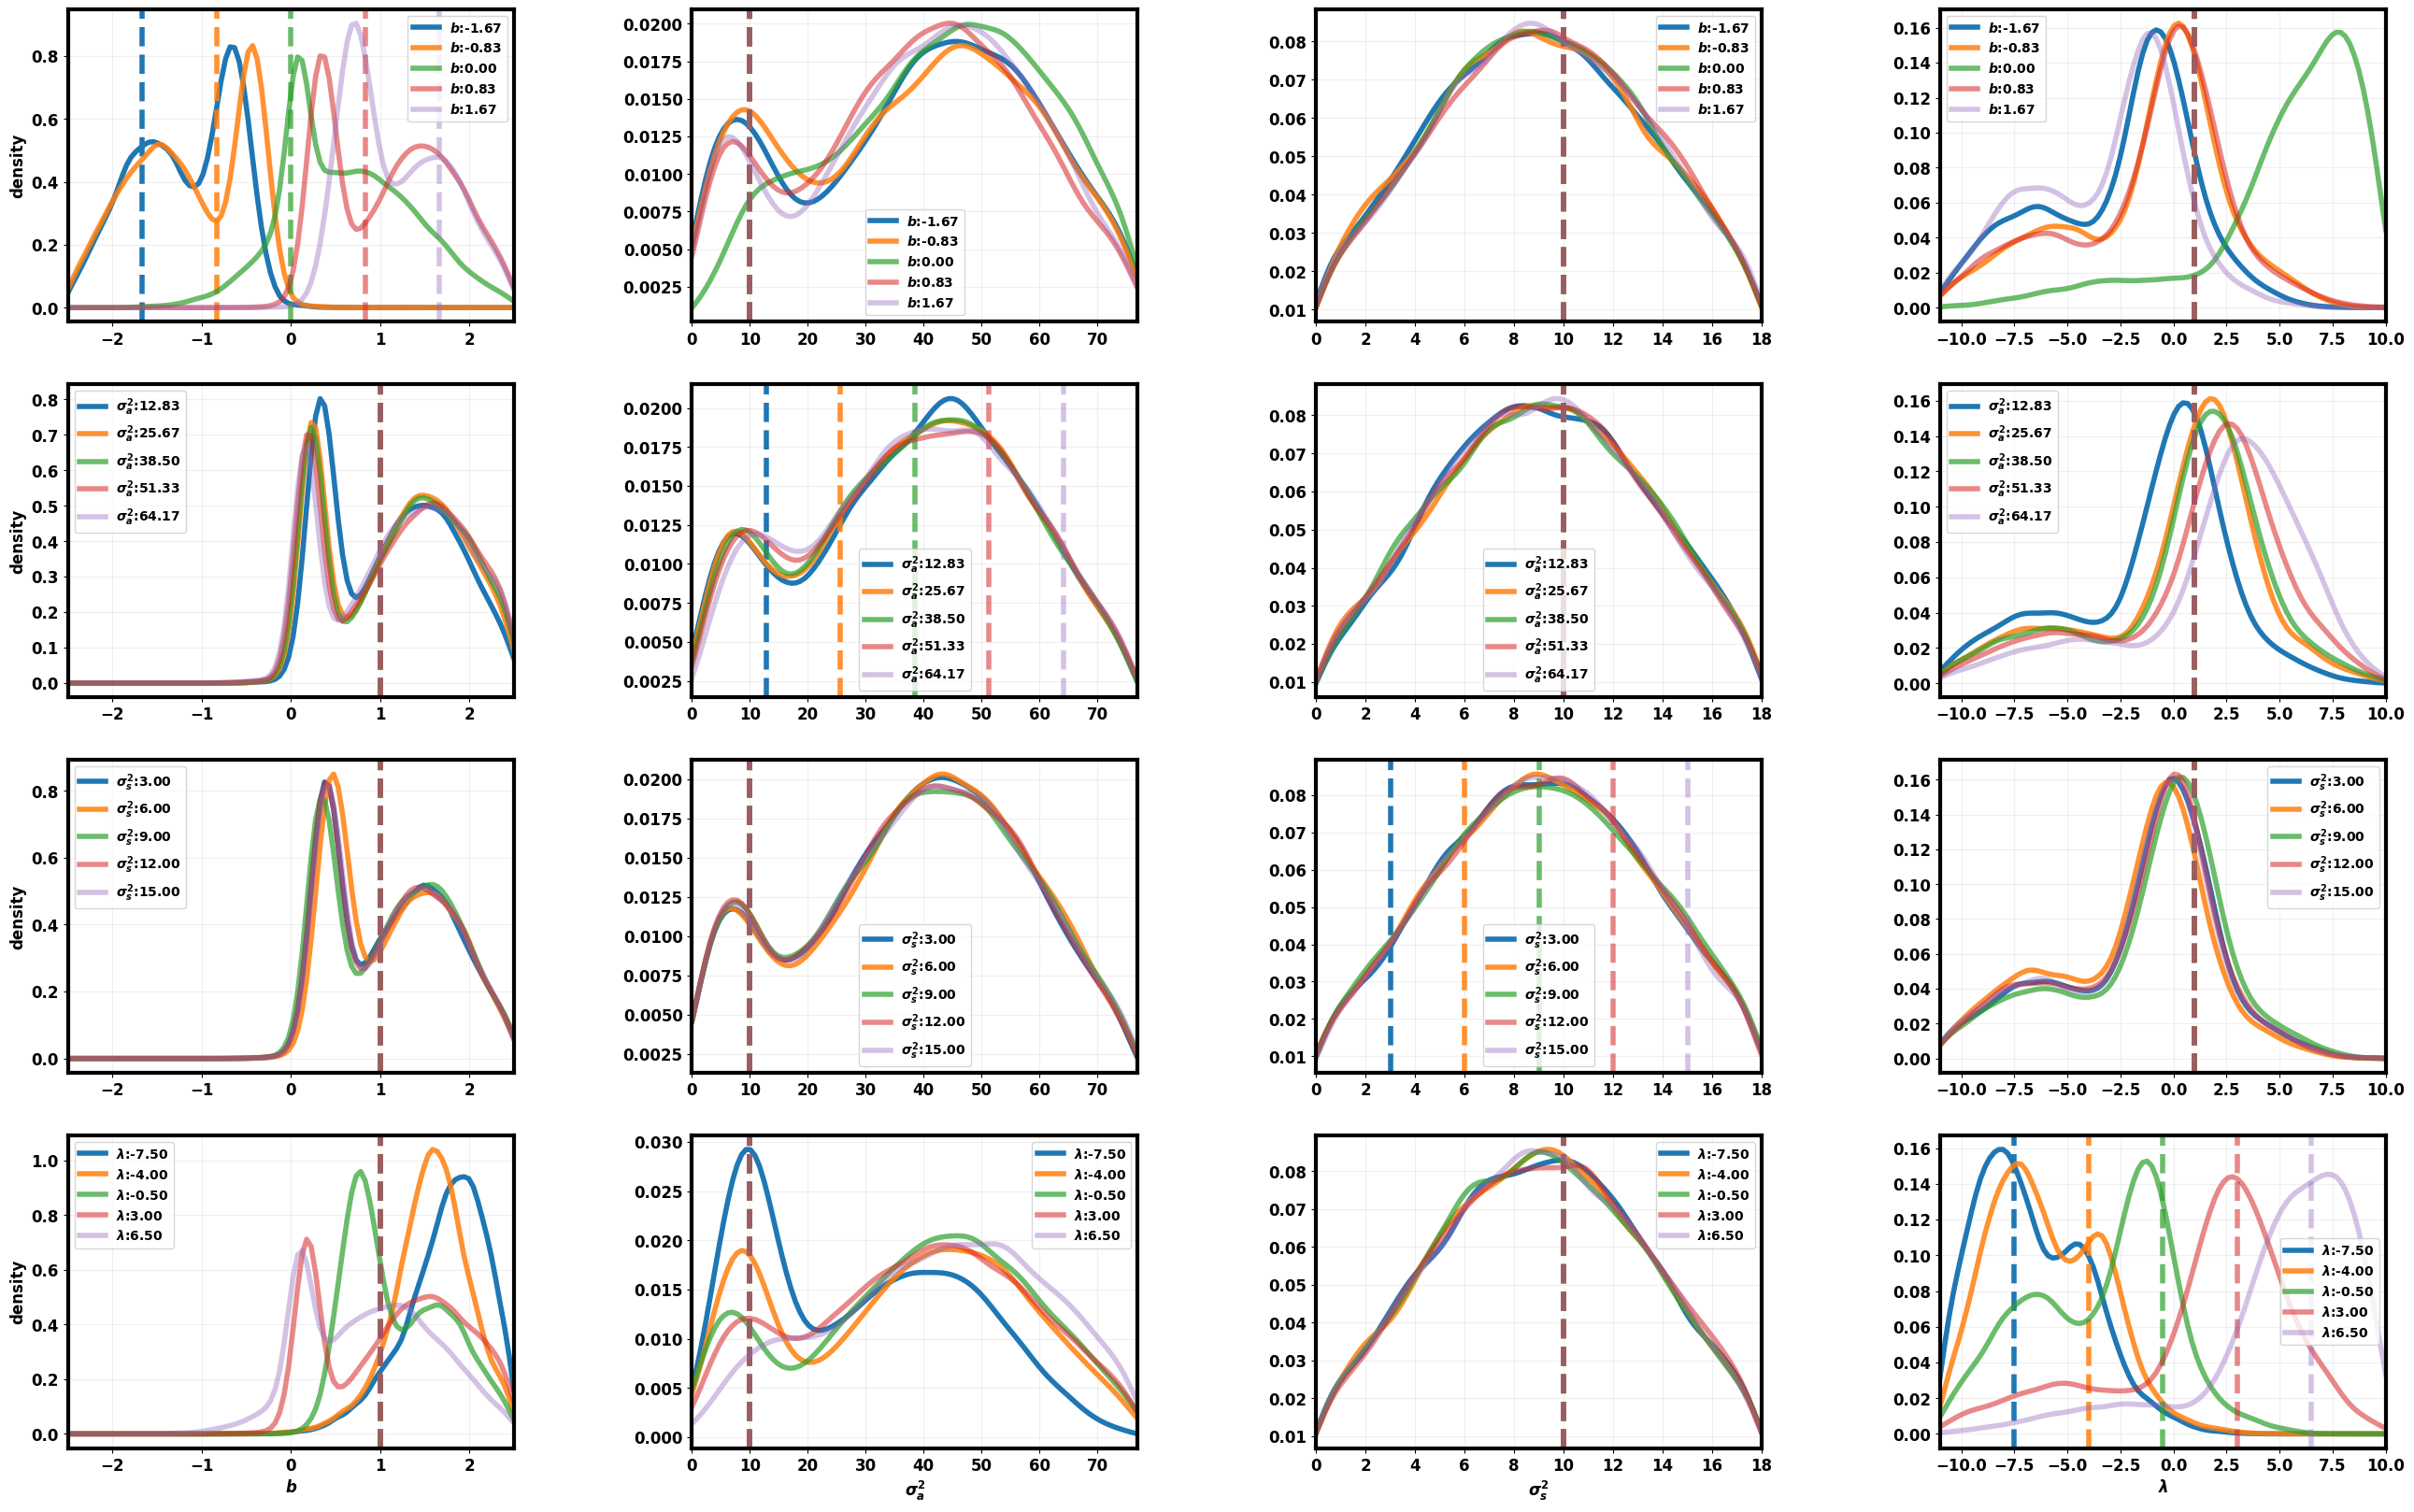

In [10]:
fig, axes = plt.subplots(
    all_thetas_dr.shape[0],
    all_thetas_dr.shape[-1],
    figsize=(all_thetas_dr.shape[-1] * 8, 5 * all_thetas_dr.shape[0]),
)
fig.subplots_adjust(wspace=0.4)
num_trials = all_thetas_dr.shape[1]

dest_limits = designed_limits

for i in range(all_thetas_dr.shape[0]):
    ax_row = axes[i, :]
    samples_row = all_samples_dr[i]
    moving_theta_idx = i

    for j in range(num_params):
        for k in range(num_trials):
            ax = ax_row[j]
            density = gaussian_kde(samples_row[k, :, j], bw_method="scott")
            xs = np.linspace(dest_limits[j][0], dest_limits[j][1], 100)
            ys = density(xs)
            ax.plot(
                xs,
                ys,
                color=colors[k],
                linewidth=4,
                label=f"{prior_labels[i]}:{all_thetas_dr[i, k, i]:.2f}",
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.set_xlim(dest_limits[j][0], dest_limits[j][1])
            ax.legend(fontsize=10)
            ax.axvline(
                all_thetas_dr[i, k, j],
                color=colors[k],
                linestyle="--",
                linewidth=4,
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.grid(alpha=0.2)
            if j == 0:
                ax.set_ylabel("density")
        
        if i == num_params-1:
            ax.set_xlabel(prior_labels[j])

save_fig = fig_dir / 'compare' / f'{log_exp_id}-CoV.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## NPE-F Inference

In [14]:
# %% ==================================================
pipeline_version = "p4a"
train_id = "train_L0_p4a"
exp_id = "p4a-F1345-cnn-maf3-tmp"
# exp_id = "p4a-F1345-cnn"
log_exp_id = "npe-f-F1345-maf3"

# %% ========== load the latest event file
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id

config_npef, model_path_npef = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver_npef, posterior_npef, _, _, _, _ = get_posterior(
    model_path=model_path_npef,
    config=config_npef,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=True,
)

/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


==>> config_path: /home/wehe/tmp/NSC/codes/src/train/logs/train_L0_p4a/p4a-F1345-cnn-maf3-tmp/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.5 GB
Cached:    0.7 GB
--- CUDA info ---

prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
cnn

=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets len_feature_each_type=[69, 15, 12, 56]
loading 18sets T100.00% C25...


 50%|█████     | 9/18 [00:00<00:00, 42.80it/s]

100%|██████████| 18/18 [00:00<00:00, 43.91it/s]


dataset info: ==> self.total_samples=225000 => self.x.shape=torch.Size([18, 500, 25, 456, 1]) self.theta.shape=torch.Size([18, 500, 4])

[validation] sets len_feature_each_type=[69, 15, 12, 56]
loading 2sets T100.00% C25...


100%|██████████| 2/2 [00:00<00:00, 53.77it/s]

dataset info: ==> self.total_samples=25000 => self.x.shape=torch.Size([2, 500, 25, 456, 1]) self.theta.shape=torch.Size([2, 500, 4])
loader_kwargs={'batch_size': 20, 'drop_last': False, 'shuffle': True, 'pin_memory': False, 'num_workers': 4, 'worker_init_fn': <function seed_worker at 0x7f0607504c10>, 'prefetch_factor': 2}

collect posterior sets... 

takes 0.85 seconds = 0.01 minutes

finished build network
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=8, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)

In [21]:
seqC_o.shape

torch.Size([6300, 1, 1, 15])

In [20]:
chosen_features_lens = config_npef.dataset.feature_lengths
n_features = sum(chosen_features_lens)

Fs = torch.zeros((nT, n_features * M))

for T_idx in tqdm(range(nT)):
    chR_ = chR[:, T_idx, C_idx].unsqueeze(-1)
    F = feature_extraction(seqC, chR_, config)
    Fs[T_idx] = F

print(f"==>> Fs.shape: {Fs.shape}")

  0%|          | 0/28 [00:00<?, ?it/s]


NameError: name 'seqC' is not defined

## NLE Inference

## Analytical Inference

In [ ]:
import pymc3 as pm

# Define the model
with pm.Model() as model:
    # Define prior for 4 parameters
    param1 = pm.Uniform('param1', lower=a1, upper=b1) # Define appropriate bounds a1, b1
    param2 = pm.Uniform('param2', lower=a2, upper=b2) # Define appropriate bounds a2, b2
    param3 = pm.Uniform('param3', lower=a3, upper=b3) # Define appropriate bounds a3, b3
    param4 = pm.Uniform('param4', lower=a4, upper=b4) # Define appropriate bounds a4, b4

    # Define likelihood
    p = your_function(x, param1, param2, param3, param4) # Define your_function to take x and 4 parameters
    likelihood = pm.Bernoulli('obs', p=p, observed=y)

    # Run MCMC
    trace = pm.sample(5000)

# Analyze the results
pm.traceplot(trace)

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

def model(x, y):
    # Priors for the 4 parameters
    param1 = pyro.sample("param1", dist.Uniform(a1, b1))
    param2 = pyro.sample("param2", dist.Uniform(a2, b2))
    param3 = pyro.sample("param3", dist.Uniform(a3, b3))
    param4 = pyro.sample("param4", dist.Uniform(a4, b4))

    # Define the likelihood function
    p = your_function(x, param1, param2, param3, param4) # Define your_function
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Bernoulli(p), obs=y)

# Convert x and y to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float)

# Setup MCMC with NUTS kernel
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=1000)
mcmc.run(x_tensor, y_tensor)

# Get posterior samples
posterior_samples = mcmc.get_samples()
